# Modeling

In [1]:
# !pip install s2sphere
# !pip install mapsplotlib

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import s2sphere

## Connect

In [2]:
conf = SparkConf().setAppName("msds697_project")
sc = SparkContext(conf=conf)
sc.setLogLevel("OFF")

In [3]:
ss = SparkSession.builder.getOrCreate()

## Join SF and NYC Data

In [258]:
nyc_sf_df = nyc_vectorized_df.union(sf_vectorized_df)

In [259]:
nyc_vectorized_df.count(), sf_vectorized_df.count()

(6174, 547)

In [260]:
(nyc_sf_df.count(), len(nyc_sf_df.columns))

(6721, 4)

In [261]:
nyc_sf_df.show(2)

+--------------------+--------------------+--------+----+
|            features|      scaledFeatures| cell_id|city|
+--------------------+--------------------+--------+----+
|(114,[5,82,110],[...|(114,[5,82,110],[...|87e9702c|  NY|
|(114,[5,83,110],[...|(114,[5,83,110],[...|89b1105c|  NY|
+--------------------+--------------------+--------+----+
only showing top 2 rows



## Run clustering

In [293]:
from pyspark.ml.clustering import KMeans

In [268]:
%%time 
n_clusters = 300

kmeans = KMeans(k=n_clusters)
kmeans_model = kmeans.fit(nyc_sf_df.select("scaledFeatures").withColumnRenamed("scaledFeatures", "features"))

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 25.9 s


In [269]:
%%time 
nyc_sf_df = kmeans_model.transform(nyc_sf_df)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.88 s


In [294]:
score = kmeans_model.computeCost(nyc_sf_df)
print("Within Set Sum of Squared Errors = " + str(score))

Within Set Sum of Squared Errors = 2.42464761323e+12


## Evaluation

### What are some examples of areas in the same cluster?

In [265]:
def vector_distance_fun(x, cluster_centers = kmeans_model.clusterCenters()):
    features, centroid = x
    centroid = cluster_centers[centroid]
    import math
    return math.sqrt(features.squared_distance(centroid))

In [266]:
vector_distance = udf(lambda x: vector_distance_fun(x), DoubleType())

In [271]:
%%time
distances_df = nyc_sf_df.withColumn("distance_from_centroid", vector_distance(struct("features", "prediction")))
distances_df.count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.73 s


In [272]:
distances_df.show(10)

+--------------------+--------------------+--------+----+----------+----------------------+
|            features|      scaledFeatures| cell_id|city|prediction|distance_from_centroid|
+--------------------+--------------------+--------+----+----------+----------------------+
|(114,[5,82,110],[...|(114,[5,82,110],[...|87e9702c|  NY|        81|    1643.6301457119366|
|(114,[5,83,110],[...|(114,[5,83,110],[...|89b1105c|  NY|       217|       9.1002835776777|
|(114,[2,35,110],[...|(114,[2,35,110],[...|89b117d4|  NY|       217|    10.189138450870066|
|(114,[2,9,31,55,1...|(114,[2,9,31,55,1...|89b45adc|  NY|        37|     87.09157934119494|
|(114,[6,81,110],[...|(114,[6,81,110],[...|89b69044|  NY|       134|    3.3802074565439164|
|(114,[6,83,110],[...|(114,[6,83,110],[...|89c14e7c|  NY|       107|     23.29423961065128|
|(114,[1,30,110],[...|(114,[1,30,110],[...|89c155ac|  NY|        81|    100.51549595019497|
|(114,[2,36,110],[...|(114,[2,36,110],[...|89c2053c|  NY|       206|     5.18411

In [332]:
from pyspark.sql.window import Window

w = Window.partitionBy(["prediction", "city"]).orderBy("distance_from_centroid")

distances_df = distances_df.withColumn('row_id', monotonically_increasing_id())

closest_distances_df = distances_df.withColumn("dist_id", 
                        first(distances_df.row_id).over(w)
                       ).filter("row_id = dist_id").\
select("city", "cell_id", "prediction", "distance_from_centroid")

closest_distances_df.orderBy("distance_from_centroid").show(3)

+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c22d14|       278|    1.4142602781381497|
|  NY|89c71324|       294|     1.502108083743399|
|  SF|8085800c|       278|    2.1698102891084283|
+----+--------+----------+----------------------+
only showing top 3 rows



In [305]:
best_cluster = closest_distances_df.orderBy("distance_from_centroid").first().prediction

In [306]:
best_cluster

278

In [318]:
closest_distances_df.filter(closest_distances_df.prediction == best_cluster).show()

+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c22d14|       278|    1.4142602781381497|
|  SF|8085800c|       278|    2.1698102891084283|
+----+--------+----------+----------------------+



In [314]:
rows = closest_distances_df.filter(closest_distances_df.prediction == best_cluster).select("cell_id").take(2)

In [315]:
cell_1, cell_2 = [r.cell_id for r in rows]
cell_1, cell_2

(u'89c22d14', u'8085800c')

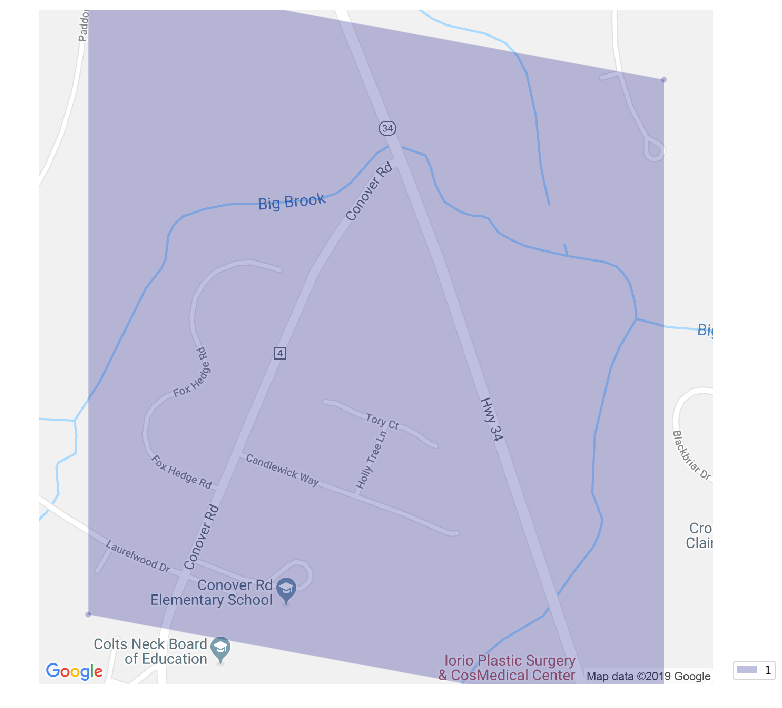

In [316]:
show_cell(cell_1)

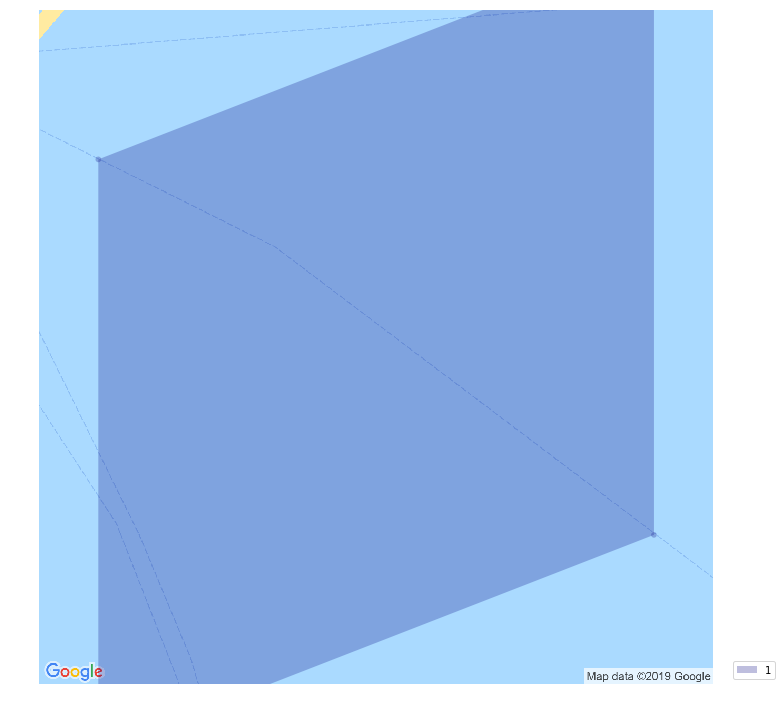

In [317]:
show_cell(cell_2)

### What part of SF is most similar to Times Square?

In [328]:
distances_df.filter(distances_df.cell_id == nyc_popular_cell_id).show()

+--------------------+--------------------+--------+----+----------+----------------------+-------------+
|            features|      scaledFeatures| cell_id|city|prediction|distance_from_centroid|       row_id|
+--------------------+--------------------+--------+----+----------+----------------------+-------------+
|[121479.0,146707....|[31.7114700421991...|89c258fc|  NY|         3|     607169.1208349548|1142461300751|
+--------------------+--------------------+--------+----+----------+----------------------+-------------+



In [331]:
distances_df.filter((distances_df.prediction == 3) & (distances_df.city == "SF")).orderBy("distance_from_centroid").show(1)

+--------------------+--------------------+--------+----+----------+----------------------+-------------+
|            features|      scaledFeatures| cell_id|city|prediction|distance_from_centroid|       row_id|
+--------------------+--------------------+--------+----+----------+----------------------+-------------+
|(114,[0,1,2,3,4,5...|(114,[0,1,2,3,4,5...|808f8504|  SF|         3|    354.05412101336424|1967095021569|
+--------------------+--------------------+--------+----+----------+----------------------+-------------+
only showing top 1 row



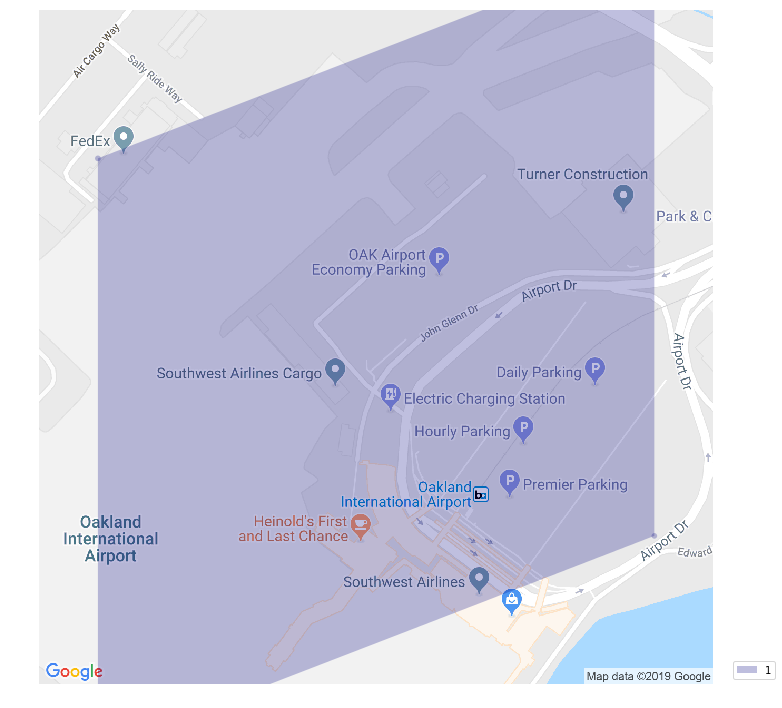

In [330]:
show_cell("808f8504")